###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c) 2019 Daniel Koehn, based on (c)2018 L.A. Barba, G.F. Forsyth [CFD Python](https://github.com/barbagroup/CFDPython#cfd-python), (c)2014 L.A. Barba, I. Hawke, B. Knaepen [Practical Numerical Methods with Python](https://github.com/numerical-mooc/numerical-mooc#practical-numerical-methods-with-python), also under CC-BY.

In [1]:
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, 'r').read())

# Iterative Methods to Solve 2D Boundary Value Problems

In [Lesson 1](http://nbviewer.ipython.org/urls/github.com/daniel-koehn/Differential-equations-earth-system/tree/master/07_BVP_2D/01_2D_Laplace_Equation.ipynb) and [Lesson 2](http://nbviewer.ipython.org/urls/github.com/daniel-koehn/Differential-equations-earth-system/tree/master/07_BVP_2D/02_2D_Poisson_Equation.ipynb) of this module we used the Jacobi method (a relaxation scheme) to iteratively find solutions to Laplace and Poisson equations.

And it worked, so why are we still talking about it?  Because the Jacobi method is slow, very slow to converge.  It might not have seemed that way in the first two notebooks because we were using small grids, but we did need more than 3,000 iterations to reach the exit criterion while solving the Poisson equation on a $41\times 41$ grid. 

You can confirm this below: using `nx,ny=` $128$ on the Laplace problem of Lesson 1, the Jacobi method requires nearly *20,000* iterations before we reach $10^{-8}$ for the L2-norm of the difference between two iterates. That's a *lot* of iterations!

Now, consider this application:  an incompressible Navier-Stokes solver has to ensure that the velocity field is divergence-free at every time step.  One of the most common ways to ensure this is to solve a Poisson equation for the pressure field. In fact, the pressure Poisson equation is responsible for the majority of the computational expense of an incompressible Navier-Stokes solver. Imagine having to do 20,000 Jacobi iterations for *every* time step in a fluid-flow problem with many thousands or perhaps millions of grid points!

The Jacobi method is the slowest of all relaxation schemes, so let's learn how to improve on it. In this lesson, we'll study the Gauss-Seidel method—twice as fast as Jacobi, in theory—and the successive over-relaxation (SOR) method. We also have some neat Python tricks lined up for you to get to the solution even faster. Let's go!

### Test problem

Let's use the same example problem as in [Lesson 1](http://nbviewer.ipython.org/urls/github.com/daniel-koehn/Differential-equations-earth-system/tree/master/07_BVP_2D/01_2D_Laplace_Equation.ipynb): Laplace's equation with boundary conditions

$$
\begin{equation}
  \begin{gathered}
p=0 \text{ at } x=0\\
\frac{\partial p}{\partial x} = 0 \text{ at } x = L_x\\
p = 0 \text{ at }y = 0 \\
p = \sin \left(  \frac{\frac{3}{2}\pi x}{L_x} \right) \text{ at } y = L_y
  \end{gathered}\notag
\end{equation}
$$

We import our favorite Python libraries, and also some custom functions that we wrote in [Lesson 1](http://nbviewer.ipython.org/urls/github.com/daniel-koehn/Differential-equations-earth-system/tree/master/07_BVP_2D/01_2D_Laplace_Equation.ipynb), which we have saved in a 'helper' Python file for re-use. 

In [2]:
import numpy
from matplotlib import pyplot
%matplotlib inline

# import JIT from Numba
from numba import jit

In [3]:
# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [4]:
from helper import laplace_solution, l2_norm, plot_3d

We now have the functions `laplace_solution`, `l2_norm`, and `plot_3d` in our namespace. If you can't remember how they work, just use the Python built-in function `help()` and take advantage of the docstrings.  It's a good habit to always write docstrings in your functions, and now you see why!

In this notebook, we are going to use larger grids than before, to better illustrate the speed increases we achieve with different iterative methods. Let's create a $128\times128$ grid and initialize.

In [5]:
# Set parameters.
nx = 128  # number of points in the x direction
ny = 128  # number of points in the y direction
Lx = 5.0  # domain length in the x direction
Ly = 5.0  # domain length in the y direction
dx = Lx / (nx - 1)  # grid spacing in x direction
dy = Ly / (ny - 1)  # grid spacing in y direction

# Create the gridline locations.
x = numpy.linspace(0.0, Lx, num=nx)
y = numpy.linspace(0.0, Ly, num=ny)

# Set the initial conditions.
p0 = numpy.zeros((ny, nx))
p0[-1, :] = numpy.sin(1.5 * numpy.pi * x / Lx)

We said above that the Jacobi method takes nearly $20,000$ iterations before it satisfies our exit criterion of $10^{-8}$ (L2-norm difference between two consecutive iterations). You'll just have to confirm that now. Have a seat!

In [6]:
@jit(nopython=True) # use Just-In-Time (JIT) Compilation for C-performance
def laplace_jac(p,pn,nx,ny):
    
    for i in range(1,nx-1):
        for j in range(1,ny-1):
            
            # Laplace equation
            p[j, i] = 0.25 * (pn[j+1, i] + pn[j, i+1] +
                              pn[j-1, i] + pn[j, i-1])
    return p   

In [7]:
def laplace_2d_jacobi(p0, maxiter=20000, rtol=1e-6):
    """
    Solves the 2D Laplace equation on a uniform grid
    with equal grid spacing in both directions
    using Jacobi relaxation method.
    
    The exit criterion of the solver is based on the relative L2-norm
    of the solution difference between two consecutive iterations.
    
    Parameters
    ----------
    p0 : numpy.ndarray
        The initial solution as a 2D array of floats.
    maxiter : integer, optional
        Maximum number of iterations to perform;
        default: 20000.
    rtol : float, optional
        Relative tolerance for convergence;
        default: 1e-6.
    
    Returns
    -------
    p : numpy.ndarray
        The solution after relaxation as a 2D array of floats.
    ite : integer
        The number of iterations performed.
    diff : float
        The final relative L2-norm of the difference.
    """
    
    # estimate nx, ny
    ny, nx = numpy.shape(p0)
    
    # copy initial guess p0
    p = p0.copy()
    
    conv = []  # convergence history
    diff = rtol + 1.0  # initial difference
    ite = 0  # iteration index
    
    while diff > rtol and ite < maxiter:
        
        # store old p-values
        pn = p.copy()
        
        # Update the solution at interior points of the Laplace equation
        p = laplace_jac(p,pn,nx,ny)
        
        # Apply 2nd-order Neumann condition (zero-gradient)
        # at the right boundary.
        p[1:-1, -1] = 0.25 * (2.0 * pn[1:-1, -2] +
                              pn[2:, -1] + pn[:-2, -1])
        
        # Compute the relative L2-norm of the difference.
        diff = numpy.sqrt(numpy.sum((p - pn)**2) / numpy.sum(pn**2))
        conv.append(diff)
        ite += 1
        
    return p, ite, conv

In [8]:
# Compute the solution using Jacobi relaxation method.
p, ites, conv_jacobi = laplace_2d_jacobi(p0, maxiter=20000, rtol=1e-8)
print('Jacobi relaxation: {} iterations '.format(ites) +
      'to reach a relative difference of {}'.format(conv_jacobi[-1]))

Jacobi relaxation: 19993 iterations to reach a relative difference of 9.998616840936991e-09


Would we lie to you? $19,993$ iterations before we reach the exit criterion of $10^{-8}$. Yikes!

We can also time how long the Jacobi method takes using the `%%timeit` cell-magic.  Go make some tea, because this can take a while—the `%%timeit` magic runs the function a few times and then averages their runtimes to give a more accurate result.  

- - -
##### Notes

1. When using `%%timeit`, the return values of a function (`p` and `iterations` in this case) *won't* be saved.

2. We document our timings below, but your timings can vary quite a lot, depending on your hardware. In fact, you may not even see the same trends (some recent hardware can play some fancy tricks with optimizations that you have no control over).
- - -

With those caveats, let's give it a shot:

In [9]:
%%timeit
laplace_2d_jacobi(p0, maxiter=20000, rtol=1e-8)

1.82 s ± 14.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The printed result above (and others to come later) is from a 2017 desktop PC, powered by a 4 GHz Intel Core i7-6700K CPU. We tried also on more modern machines, and got conflicting results—like the Gauss-Seidel method being slightly slower than Jacobi, even though it required fewer iterations. Don't get too hung up on this: the hardware optimizations applied by more modern CPUs are varied and make a big difference sometimes.

Meanwhile, let's check the overall accuracy of the numerical calculation by comparing it to the analytical solution.

In [10]:
# Compute the analytical solution.
p_exact = laplace_solution(x, y, Lx, Ly)

# Compute the relative L2-norm of the error.
l2_norm(p, p_exact)

6.17355133529885e-05

That's a pretty small error. Let's assume it is good enough and focus on speeding up the process.

## Gauss-Seidel

You will recall from [Lesson 1](http://nbviewer.ipython.org/urls/github.com/daniel-koehn/Differential-equations-earth-system/tree/master/07_BVP_2D/01_2D_Laplace_Equation.ipynb) that a single Jacobi iteration is written as:

$$
\begin{equation}
p^{k+1}_{i,j} = \frac{1}{4} \left(p^{k}_{i,j-1} + p^k_{i,j+1} + p^{k}_{i-1,j} + p^k_{i+1,j} \right) \tag{1}
\end{equation}
$$

The Gauss-Seidel method is a simple tweak to this idea: use updated values of the solution as soon as they are available, instead of waiting for the values in the whole grid to be updated. 

If you imagine that we progress through the grid points in the order shown by the arrow in Figure 1, then you can see that the updated values $p^{k+1}_{i-1,j}$ and $p^{k+1}_{i,j-1}$ can be used to calculate $p^{k+1}_{i,j}$.

<img src="./figures/solvepath.svg" width=350>

#### Figure 1. Assumed order of updates on a grid.

The iteration formula for Gauss-Seidel is thus:

$$
\begin{equation}
p^{k+1}_{i,j} = \frac{1}{4} \left(p^{k+1}_{i,j-1} + p^k_{i,j+1} + p^{k+1}_{i-1,j} + p^k_{i+1,j} \right) \tag{2}
\end{equation}
$$

In the function `laplace_gauss`, we compute the Gauss-Seidel updates. Compare the code with the `laplace_jac` function.

In [11]:
@jit(nopython=True) # use Just-In-Time (JIT) Compilation for C-performance
def laplace_gauss(p,nx,ny):
    
    for i in range(1,nx-1):
        for j in range(1,ny-1):
            
            # Solution of the Laplace equation using the Gauss-Seidel method
            p[j, i] = 0.25 * (p[j+1, i] + p[j, i+1] +
                              p[j-1, i] + p[j, i-1])
            
    return p   

To solve the Laplace problem with the Gauss-Seidel method, we use the code `laplace_2d_gauss_seidel`

In [12]:
def laplace_2d_gauss_seidel(p0, maxiter=20000, rtol=1e-6):
    """
    Solves the 2D Laplace equation on a uniform grid
    with equal grid spacing in both directions
    using Gauss-Seidel relaxation method.
    
    The exit criterion of the solver is based on the relative L2-norm
    of the solution difference between two consecutive iterations.
    
    Parameters
    ----------
    p0 : numpy.ndarray
        The initial solution as a 2D array of floats.
    maxiter : integer, optional
        Maximum number of iterations to perform;
        default: 20000.
    rtol : float, optional
        Relative tolerance for convergence;
        default: 1e-6.
    
    Returns
    -------
    p : numpy.ndarray
        The solution after relaxation as a 2D array of floats.
    ite : integer
        The number of iterations performed.
    diff : float
        The final relative L2-norm of the difference.
    """
    
    # estimate nx, ny
    ny, nx = numpy.shape(p0)
    
    # copy initial guess p0
    p = p0.copy()
    
    conv = []  # convergence history
    diff = rtol + 1.0  # initial difference
    ite = 0  # iteration index
    
    while diff > rtol and ite < maxiter:
        
        # store old value p
        pn = p.copy()

        # Update the solution at interior points of the Laplace equation
        p = laplace_gauss(p,nx,ny)
                
        # Apply 2nd-order Neumann condition (zero-gradient)
        # at the right boundary.
        for j in range(1, ny - 1):
            p[j, -1] = 0.25 * (2.0 * p[j, -2] +
                               p[j - 1, -1] + p[j + 1, -1])
            
        # Compute the relative L2-norm of the difference.
        diff = l2_norm(p, pn)
        conv.append(diff)
        ite += 1
        
    return p, ite, conv

Let's test the code performance

In [13]:
# Compute the solution using Gauss-Seidel relaxation method.
p, ites, conv_gs = laplace_2d_gauss_seidel(p0,maxiter=20000, rtol=1e-8)
print('Gauss-Seidel relaxation: {} iterations '.format(ites) +
      'to reach a relative difference of {}'.format(conv_gs[-1]))

Gauss-Seidel relaxation: 13939 iterations to reach a relative difference of 9.997635654127444e-09


Cool! Using the most recently updated values of the solution in the Gauss-Seidel method saved 6,000 iterations! Now we can see how much faster than Jacobi this is, because both methods are implemented the same way:

In [14]:
%%timeit
laplace_2d_gauss_seidel(p0, maxiter=20000, rtol=1e-8)

2.76 s ± 1.75 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We get no speed-up over the Numba version of Jacobi, and you may see different results. This can be confusing, and hard to explain without getting into the nitty grity of hardware optimizations.

Don't lose hope! We have another trick up our sleeve!

## Successive Over-Relaxation (SOR)

Successive over-relaxation is able to improve on the Gauss-Seidel method by using in the update a linear combination of the previous and the current solution, as follows:

$$
\begin{equation}
p^{k+1}_{i,j} = (1 - \omega)p^k_{i,j} + \frac{\omega}{4} \left(p^{k+1}_{i,j-1} + p^k_{i,j+1} + p^{k+1}_{i-1,j} + p^k_{i+1,j} \right) \tag{3}
\end{equation}
$$

The relaxation parameter $\omega$ will determine how much faster SOR will be than Gauss-Seidel. SOR iterations are only stable for $0 < \omega < 2$. Note that for $\omega = 1$, SOR reduces to the Gauss-Seidel method.

If $\omega < 1$, that is technically an "under-relaxation" and it will be slower than Gauss-Seidel.  

If $\omega > 1$, that's the over-relaxation and it should converge faster than Gauss-Seidel.  

Let's write a function for SOR iterations of the Laplace equation, using Numba to get high performance.

In [15]:
@jit(nopython=True) # use Just-In-Time (JIT) Compilation for C-performance
def laplace_SOR(p,nx,ny,omega):
    
    for i in range(1,nx-1):
        for j in range(1,ny-1):
            
            # Solution of the Laplace equation using the Gauss-Seidel method
            p[j, i] = ((1.0 - omega) * p[j, i] +
                        omega * 0.25 *(p[j, i - 1] + p[j, i + 1] +
                                       p[j - 1, i] + p[j + 1, i]))
            
    return p   

In [16]:
def laplace_2d_sor(p0, omega, maxiter=20000, rtol=1e-6):
    """
    Solves the 2D Laplace equation on a uniform grid
    with equal grid spacing in both directions
    using successive over-relaxation (SOR) method.
    
    The exit criterion of the solver is based on the relative L2-norm
    of the solution difference between two consecutive iterations.
    
    Parameters
    ----------
    p0 : numpy.ndarray
        The initial solution as a 2D array of floats.
    omega : float
        Relaxation parameter.
    maxiter : integer, optional
        Maximum number of iterations to perform;
        default: 20000.
    rtol : float, optional
        Relative tolerance for convergence;
        default: 1e-6.
    
    Returns
    -------
    p : numpy.ndarray
        The solution after relaxation as a 2D array of floats.
    ite : integer
        The number of iterations performed.
    conv : list
        The convergence history as a list of floats.
    """
    
    # estimate nx, ny
    ny, nx = p0.shape
    
    # copy initial guess p0
    p = p0.copy()
    
    conv = []  # convergence history
    diff = rtol + 1.0  # initial difference
    ite = 0  # iteration index
    
    while diff > rtol and ite < maxiter:
        
        # store old value p
        pn = p.copy()
        
        # Update the solution at interior points of the Laplace equation
        p = laplace_SOR(p,nx,ny,omega)
        
        # Apply 2nd-order Neumann condition (zero-gradient)
        # at the right boundary.
        for j in range(1, ny - 1):
            p[j, -1] = 0.25 * (2.0 * p[j, -2] +
                               p[j - 1, -1] + p[j + 1, -1])
            
        # Compute the relative L2-norm of the difference.
        diff = numpy.sqrt(numpy.sum((p - pn)**2) / numpy.sum(pn**2))
        conv.append(diff)
        ite += 1
        
    return p, ite, conv

That wasn't too bad at all.  Let's try this out first with $\omega = 1$ and check that it matches the Gauss-Seidel results from above.

In [17]:
# Compute the solution using SOR method.
omega = 1.0
p, ites, conv_sor = laplace_2d_sor(p0, omega, maxiter=20000, rtol=1e-8)
print('SOR (omega={}): {} iterations '.format(omega, ites) +
      'to reach a relative difference of {}'.format(conv_sor[-1]))

SOR (omega=1.0): 13939 iterations to reach a relative difference of 9.997635652064388e-09


We have the exact same number of iterations as Gauss-Seidel.  That's a good sign that things are working as expected.

Now let's try to over-relax the solution and see what happens.  To start, let's try $\omega = 1.5$.

In [18]:
# Compute the solution using SOR method.
omega = 1.5
p, ites, conv_sor = laplace_2d_sor(p0, omega, maxiter=20000, rtol=1e-8)
print('SOR (omega={}): {} iterations '.format(omega, ites) +
      'to reach a relative difference of {}'.format(conv_sor[-1]))

SOR (omega=1.5): 7108 iterations to reach a relative difference of 9.991011447055278e-09


Wow!  That really did the trick!  We dropped from $13,939$ iterations down to $7,108$. Now we're really cooking! Let's try `%%timeit` on SOR.

In [19]:
%%timeit
laplace_2d_sor(p0, omega, maxiter=20000, rtol=1e-8)

1.51 s ± 839 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Things continue to speed up. But we can do even better!

### Tuned SOR

Above, we picked $\omega=1.5$ arbitrarily, but we would like to over-relax the solution as much as possible without introducing instability, as that will result in the fewest number of iterations.

For square domains, it turns out that the ideal factor $\omega$ can be computed as a function of the number of nodes in one direction, e.g., `nx`.

$$
\begin{equation}
\omega \approx \frac{2}{1+\frac{\pi}{nx}}
\end{equation}
$$

This is not some arbitrary formula, but its derivation lies outside the scope of this course. (If you're curious and have some serious math chops, you can check out Reference 3 for more information). For now, let's try it out and see how it works.

In [20]:
# Compute the solution using tuned SOR method.
omega = 2.0 / (1.0 + numpy.pi / nx)
p, ites, conv_opt_sor = laplace_2d_sor(p0, omega, maxiter=20000, rtol=1e-8)
print('SOR (omega={:.4f}): {} iterations '.format(omega, ites) +
      'to reach a relative difference of {}'.format(conv_opt_sor[-1]))

SOR (omega=1.9521): 1110 iterations to reach a relative difference of 9.96428390785594e-09


Wow! That's *very* fast. Also, $\omega$ is very close to the upper limit of 2. SOR tends to work fastest when $\omega$ approaches 2, but don't be tempted to push it.  Set $\omega = 2$ and the walls will come crumbling down.

Let's see what `%%timeit` has for us now.

In [21]:
%%timeit
laplace_2d_sor(p0, omega, maxiter=20000, rtol=1e-8)

236 ms ± 141 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Regardless of the hardware in which we tried this, the tuned SOR gave *big* speed-ups, compared to the Jacobi method (whether implemented with NumPy or Numba). Now you know why we told you at the end of [Lesson 1](http://nbviewer.ipython.org/urls/github.com/daniel-koehn/Differential-equations-earth-system/tree/master/07_BVP_2D/01_2D_Laplace_Equation.ipynb) that the Jacobi method is the *worst* iterative solver and almost never used.

Just to convince ourselves that everything is OK, let's check the error after the $1,110$ iterations of tuned SOR:

In [22]:
# Compute the relative L2-norm of the error.
l2_norm(p, p_exact)

7.792743355064554e-05

Looking very good, indeed.

We didn't explain it in any detail, but notice the very interesting implication of Equation $(6)$: the ideal relaxation factor is a function of the grid size.  
Also keep in mind that the formula only works for square domains with uniform grids. If your problem has an irregular geometry, you will need to find a good value of $\omega$ by numerical experiments.

## Decay of the difference between iterates

In the [Poisson Equation notebook](http://nbviewer.ipython.org/urls/github.com/daniel-koehn/Differential-equations-earth-system/tree/master/07_BVP_2D/02_2D_Poisson_Equation.ipynb), we noticed how the norm of the difference between consecutive iterations first dropped quite fast, then settled for a more moderate decay rate. With Gauss-Seidel, SOR and tuned SOR, we reduced the number of iterations required to reach the stopping criterion. Let's see how that reflects on the time history of the difference between consecutive solutions.

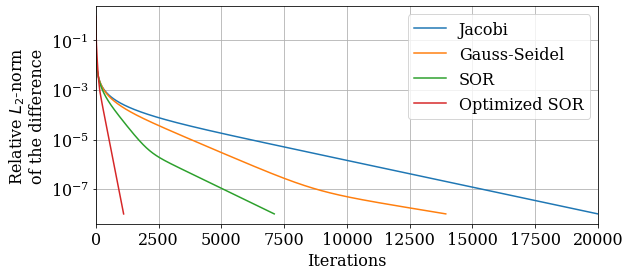

In [23]:
# Plot the convergence history for different methods.
pyplot.figure(figsize=(9.0, 4.0))
pyplot.xlabel('Iterations')
pyplot.ylabel('Relative $L_2$-norm\nof the difference')
pyplot.grid()
pyplot.semilogy(conv_jacobi, label='Jacobi')
pyplot.semilogy(conv_gs, label='Gauss-Seidel')
pyplot.semilogy(conv_sor, label='SOR')
pyplot.semilogy(conv_opt_sor, label='Optimized SOR')
pyplot.legend()
pyplot.xlim(0, 20000);

The Jacobi method starts out with very fast convergence, but then it settles into a slower rate. Gauss-Seidel shows a faster rate in the first few thousand iterations, but it seems to be slowing down towards the end. SOR is a lot faster to converge, though, and optimized SOR just plunges down!

## References

1.  [Gonsalves, Richard J.  Computational Physics I. State University of New York, Buffalo: (2011): Section 3.1 ](http://www.physics.buffalo.edu/phy410-505/2011/index.html)

2. Moin, Parviz, "Fundamentals of Engineering Numerical Analysis," Cambridge University Press, 2nd edition (2010).

3. Young, David M. "A bound for the optimum relaxation factor for the successive overrelaxation method." Numerische Mathematik 16.5 (1971): 408-413.